# 2D U-Net
Here we train 2D U-Net for lung tumor segmentation. <br />

# Notebook-friendly plotting and training imports

This code ensures a Jupyter-compatible Matplotlib backend for inline plots, then imports the core libraries needed for training and monitoring models (PyTorch, Lightning, TensorBoard logging, checkpointing), data augmentation (imgaug), progress bars, and animation tools for visualizing results.

In [44]:
import matplotlib
# Force a Jupyter inline-capable backend if it's not already
if 'inline' not in matplotlib.get_backend().lower():
    try:
        matplotlib.use('module://matplotlib_inline.backend_inline')
    except Exception as e:
        print("Backend set error:", e)

In [45]:
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera

In [46]:
from pathlib import Path
import importlib.util, os

# put the folder with dataset.py/model.py on sys.path
import sys
sys.path.insert(0, r"E:/DoNotTouch/projects/LANSCLC/CIS_5810")

import dataset   # loads dataset.py
import model     # loads model.py

LungDataset = dataset.LungDataset
UNet        = model.UNet

print(LungDataset.__module__)  # should print "dataset"

dataset


# Data augmentation pipeline (ImgAug) with affine + elastic transforms
This defines an ImgAug Sequential augmentation pipeline that applies:

Affine transforms — random translations (±15%), zoom (0.85–1.15×), and rotations (–45° to 45°).

Elastic deformation — smooth, non-rigid distortions to improve robustness.

In [47]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

# Set seed, define 2D U-Net data splits, and build slice datasets
This code fixes random seeds and CUDA settings for reproducibility, defines the base directory for preprocessed 2D U-Net data, and constructs train/validation/test paths for a chosen fold (e.g., fold0). It then creates slice-level LungDataset objects for training (with optional augmentation), validation, and testing, and prints how many slices are in each split.

In [48]:
from pathlib import Path
import numpy as np, torch, pytorch_lightning as pl

SEED = 1337
pl.seed_everything(SEED, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BASE     = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")
PRE_ROOT = BASE / "Preprocessed_for_2D_Unet" / "splits"

FOLD_NAME = "fold0"   # change to "fold1", ..., "fold4" later

train_path = PRE_ROOT / "train" / FOLD_NAME / "train"
val_path   = PRE_ROOT / "train" / FOLD_NAME / "val"
test_path  = PRE_ROOT / "test"

print("train_path:", train_path)
print("val_path:  ", val_path)
print("test_path: ", test_path)

# seq = your imgaug.Sequential([...])  # define somewhere
# or set seq = None if you don't want augmentation

train_dataset = LungDataset(train_path, seq)
val_dataset   = LungDataset(val_path,   None)
test_dataset  = LungDataset(test_path,  None)

print(
    f"There are {len(train_dataset)} train slices, "
    f"{len(val_dataset)} val slices, "
    f"and {len(test_dataset)} test slices",
)

Seed set to 1337


train_path: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train
val_path:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\val
test_path:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train\label_gtvp (exists=True)
[LungDataset] Found 10574 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train\image
[LungDataset] Built 10574 image–label 

## Analyze slice-level tumor prevalence in the 2D training dataset
This code temporarily disables data augmentation, scans every slice in the training dataset, and flags whether each slice contains any tumor. It then reports how many slices are positive vs. negative and their class fractions. This helps quantify class imbalance at the slice level and provides a data-driven estimate of the positive-slice fraction that can be used later for loss weighting or sampling strategies.

In [49]:
from tqdm import tqdm
import numpy as np
from contextlib import contextmanager

@contextmanager
def disable_aug(ds):
    """
    Temporarily disable augmentation for a LungDataset that uses `seq`
    as the imgaug pipeline.
    """
    prev = getattr(ds, "seq", None)
    try:
        ds.seq = None
        yield ds
    finally:
        ds.seq = prev


def has_tumor(mask, thr=0.5):
    """
    Returns 1 if the mask contains any positive voxel, else 0.
    Works with torch tensors or numpy arrays with shape (1,H,W) or (H,W).
    """
    a = np.asarray(mask)
    a = np.squeeze(a)          # (1,H,W) -> (H,W)

    if np.issubdtype(a.dtype, np.floating):
        return int((a > thr).any())
    else:
        return int((a > 0).any())


def scan_dataset(ds, name: str = "train"):
    """
    Scan a dataset and return an array of 0/1 tumor flags
    for ALL slices in that dataset.
    """
    with disable_aug(ds):
        targets = []
        for i in tqdm(range(len(ds)), desc=f"Scanning {name} slices"):
            _, label = ds[i]   # label is a torch tensor (1,H,W)
            targets.append(has_tumor(label))

    targets = np.array(targets, dtype=np.int64)
    pos = int(targets.sum())
    total = len(targets)
    print(f"[{name}] positives: {pos}/{total} ({100 * pos / total:.1f}%)")

    # per-class counts and fractions
    vals, counts = np.unique(targets, return_counts=True)
    frac = counts / counts.sum()
    class_fractions = dict(zip(vals.tolist(), frac.tolist()))
    print(f"[{name}] class fractions (value -> fraction): {class_fractions}")

    return targets, class_fractions


# ----- use ONLY the training set for this fold -----
train_targets, train_class_fractions = scan_dataset(train_dataset, "train")

# For convenience: fraction of positive (tumor) slices in TRAIN ONLY
pos_fraction = train_class_fractions.get(1, 0.0)
print(f"[train] positive-slice fraction used for weights: {pos_fraction:.4f}")


Scanning train slices:  68%|███████████████████████████████████▊                 | 7156/10574 [00:13<00:06, 562.71it/s]


Scanning train slices: 100%|████████████████████████████████████████████████████| 10574/10574 [00:20<00:00, 526.37it/s]

[train] positives: 2482/10574 (23.5%)
[train] class fractions (value -> fraction): {0: 0.7652733118971061, 1: 0.2347266881028939}
[train] positive-slice fraction used for weights: 0.2347


# Compute and print final class fractions for training slices
This code recomputes the proportion of negative (0) and positive (1) slices in the training set by counting occurrences of each label, converting them to fractions, and printing a dictionary mapping class value → fraction. It’s a concise summary of class balance in the 2D training data.

In [50]:
vals_train, counts_train = np.unique(train_targets, return_counts=True)
fractions_train = counts_train / counts_train.sum()
class_fractions_train = dict(zip(vals_train.tolist(), fractions_train.tolist()))
print(f"[train] class fractions (value -> fraction): {class_fractions_train}")

[train] class fractions (value -> fraction): {0: 0.7652733118971061, 1: 0.2347266881028939}


# Retrieve the positive-slice fraction for weighting
This code extracts the fraction of tumor-positive slices (class 1) from the previously computed training class fractions. If class 1 is absent, it defaults to 0. It then prints the value with four-decimal precision, which can be used later for loss weighting or sampling strategies.

In [51]:
# For convenience: fraction of positive (tumor) slices in TRAIN ONLY
pos_fraction = train_class_fractions.get(1, 0.0)
print(f"[train] positive-slice fraction used for weights: {pos_fraction:.4f}")

[train] positive-slice fraction used for weights: 0.2347


# Compute class-balanced slice weights for training
This code first counts positive and negative slices in the training set and prints the class imbalance. If both classes are present, it assigns class-balanced sampling weights so positives and negatives each contribute about 50% of the sampling probability (w_pos ∝ 1/N_pos, w_neg ∝ 1/N_neg). It then builds a per-slice weight_list over all training slices, which can be used with a weighted sampler to counteract class imbalance.

In [52]:
# After you have this from the previous code:
# train_targets, train_class_fractions = scan_dataset(train_dataset, "train")   # 0/1 per train slice

# ----- 1) Use TRAIN ONLY to estimate class imbalance for this fold -----
N_train = len(train_targets)
N_pos   = int(train_targets.sum())
N_neg   = N_train - N_pos

print(f"[train] positives: {N_pos}/{N_train} ({100.0 * N_pos / N_train:.1f}%)")

if N_pos == 0 or N_neg == 0:
    print("[WARN] One class missing in train set, falling back to uniform weights.")
    w_pos = w_neg = 1.0
else:
    # class-balanced: each class contributes ~0.5 of sampling probability
    w_pos = 0.5 / N_pos
    w_neg = 0.5 / N_neg

print(f"[train] w_neg={w_neg:.4e}, w_pos={w_pos:.4e}")

# ----- 2) Build weight_list for the TRAIN set only -----
weight_list = []
for t in train_targets:      # t is 0 or 1
    if t == 0:
        weight_list.append(w_neg)
    else:
        weight_list.append(w_pos)

weight_list = np.asarray(weight_list, dtype=np.float32)
print("First 20 weights:", weight_list[:20])

[train] positives: 2482/10574 (23.5%)
[train] w_neg=6.1789e-05, w_pos=2.0145e-04
First 20 weights: [6.1789418e-05 6.1789418e-05 6.1789418e-05 6.1789418e-05 6.1789418e-05
 6.1789418e-05 6.1789418e-05 6.1789418e-05 6.1789418e-05 2.0145044e-04
 2.0145044e-04 2.0145044e-04 6.1789418e-05 2.0145044e-04 2.0145044e-04
 2.0145044e-04 2.0145044e-04 2.0145044e-04 2.0145044e-04 2.0145044e-04]


# Build per-fold datasets and class-balanced slice sampler
This code builds 2D U-Net datasets for each cross-validation fold (train/val/test slice sets from preprocessed NIfTI folders) and then constructs a WeightedRandomSampler that balances tumor vs non-tumor slices. Augmentation is temporarily disabled while scanning, so slice labels reflect the true masks. Each slice is tagged as tumor/non-tumor by checking whether its mask has any positive voxels, and class-balanced weights are computed so that positives and negatives are sampled with roughly equal probability during training, mitigating slice-level class imbalance.

In [54]:
from contextlib import contextmanager
import numpy as np

@contextmanager
def disable_aug(ds):
    prev = getattr(ds, "seq", None)
    try:
        ds.seq = None
        yield ds
    finally:
        ds.seq = prev

def has_tumor(mask, thr=0.5):
    """Return 1 if any positive voxel exists, else 0."""
    a = np.asarray(mask)
    a = np.squeeze(a)  # (1,H,W) -> (H,W)
    if np.issubdtype(a.dtype, np.floating):
        return int((a > thr).any())
    else:
        return int((a > 0).any())

from pathlib import Path

BASE     = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")
PRE_ROOT = BASE / "Preprocessed_for_2D_Unet" / "splits"

def build_datasets_for_fold(fold_idx, seq_train=None):
    fold_name = f"fold{fold_idx}"
    train_path = PRE_ROOT / "train" / fold_name / "train"
    val_path   = PRE_ROOT / "train" / fold_name / "val"
    test_path  = PRE_ROOT / "test"        # same test for all folds

    print(f"\n=== Fold {fold_name} paths ===")
    print("  train:", train_path)
    print("  val:  ", val_path)
    print("  test: ", test_path)

    train_ds = LungDataset(train_path, seq_train)
    val_ds   = LungDataset(val_path,   None)
    test_ds  = LungDataset(test_path,  None)

    print(
        f"[Fold {fold_name}] slices -> "
        f"train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}"
    )
    return train_ds, val_ds, test_ds

import torch
from tqdm import tqdm

def compute_sampler_for_dataset(ds):
    """
    Build a WeightedRandomSampler so that tumor / non-tumor slices are
    roughly balanced.
    """
    targets = []

    with disable_aug(ds):              # turn off imgaug
        for i in tqdm(range(len(ds)), desc="Scanning slices for class balance"):
            _, mask = ds[i]           # mask: (1,H,W) torch tensor
            targets.append(has_tumor(mask))

    targets = np.array(targets, dtype=np.int64)
    N = len(targets)
    N_pos = targets.sum()
    N_neg = N - N_pos

    print(f"  positives: {N_pos}/{N} ({100.0*N_pos/N:.1f}%)")

    # Avoid div by zero
    if N_pos == 0 or N_neg == 0:
        print("  [WARN] Imbalanced to single class; using uniform weights.")
        weights = np.ones(N, dtype=np.float32)
    else:
        # class-balanced weights: each class contributes ~0.5 prob mass
        w_pos = 0.5 / N_pos
        w_neg = 0.5 / N_neg
        weights = np.where(targets == 1, w_pos, w_neg).astype(np.float32)

    weights_t = torch.as_tensor(weights, dtype=torch.float32)
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=weights_t,
        num_samples=len(weights_t),
        replacement=True,
    )
    return sampler

# Live training curves and robust 2D U-Net tumor segmentation module

This block sets up a Lightning callback that live-updates and saves loss/Dice curves every epoch, then defines a numerically robust Dice metric and a 2D U-Net–based TumorSegmentation LightningModule. The model uses BCE-with-logits loss plus a batch Dice score, guards against NaNs/±Inf, and accumulates epoch-mean train loss/Dice explicitly so the plotting callback always has clean values. It also logs validation metrics and can optionally log example prediction vs. ground-truth overlay images to TensorBoard, giving stable, interpretable feedback during 2D slice-based training.

In [55]:
# Imports – run this first in the notebook
import torch
import torch.nn as nn                    # <-- fixes NameError: nn
import numpy as np
import matplotlib.pyplot as plt

import pytorch_lightning as pl           # use ONE namespace
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from IPython.display import display
from pathlib import Path
from typing import Optional, Union   # <-- add this line

# --------------------------------------------------
# LiveEpochCurves callback: display + save per epoch
# --------------------------------------------------
class LiveEpochCurves(pl.Callback):
    """
    - Shows a 2-panel figure (Loss & Dice) that updates every epoch.
    - Saves two PNGs every epoch:
        save_dir / f"{base_filename}_loss.png"
        save_dir / f"{base_filename}_dice.png"
      (files are overwritten each epoch)
    """

    def __init__(
        self,
        title: str = "2D U-Net — Fold 0",
        save_dir: Optional[Union[str, Path]] = None,
        base_filename: Optional[str] = None,
    ):
        super().__init__()
        self.title = title
        self.save_dir = Path(save_dir) if save_dir is not None else None
        self.base_filename = base_filename

        # histories
        self.history = {
            "epoch": [],
            "train_loss": [],
            "val_loss": [],
            "train_dice": [],
            "val_dice": [],
        }

        self._display_handle = None
        self._pend_train = {}

        if self.save_dir is not None:
            self.save_dir.mkdir(parents=True, exist_ok=True)

    # ------------- metric helpers -------------

    @staticmethod
    def _f(v):
        try:
            return float(v.detach().cpu()) if hasattr(v, "detach") else float(v)
        except Exception:
            return float("nan")

    @staticmethod
    def _cands(split: str, kind: str):
        """
        Possible metric names Lightning might use, plus our manual epoch means.
        """
        b = f"{split}_{kind}"
        extra = []
        if split == "train":
            extra += [
                f"{b}_epoch",
                f"{b}_epoch_mean",
                "train_loss_epoch_mean" if kind == "loss" else "train_dice_epoch_mean",
            ]
        return [
            b,
            f"{b}_epoch",
            f"{b}/dataloader_idx_0",
            f"{b}_epoch/dataloader_idx_0",
            f"{split}/{kind}",
            f"{kind}/{split}",
        ] + extra

    def _get_metric(self, split: str, kind: str, trainer):
        pools = [trainer.callback_metrics, getattr(trainer, "logged_metrics", {})]
        for pool in pools:
            for name in self._cands(split, kind):
                if name in pool:
                    return self._f(pool[name])
        return float("nan")

    # ------------- Lightning hooks -------------

    def on_train_epoch_end(self, trainer, pl_module):
        # store train metrics so they align with val epoch
        self._pend_train = {
            "train_loss": self._get_metric("train", "loss", trainer),
            "train_dice": self._get_metric("train", "dice", trainer),
        }

        # if no val loop, plot immediately with NaN val
        if not getattr(trainer, "val_dataloaders", None):
            self._append_and_plot(
                trainer.current_epoch,
                {
                    **self._pend_train,
                    "val_loss": float("nan"),
                    "val_dice": float("nan"),
                },
            )
            self._pend_train = {}

    def on_validation_epoch_end(self, trainer, pl_module):
        # prefer stored train metrics; if NaN, fall back to manual accumulators
        tl = self._pend_train.get("train_loss", self._get_metric("train", "loss", trainer))
        td = self._pend_train.get("train_dice", self._get_metric("train", "dice", trainer))

        if (not np.isfinite(tl)) and getattr(pl_module, "_train_count", 0) > 0:
            tl = float(pl_module._train_loss_sum) / float(pl_module._train_count)
        if (not np.isfinite(td)) and getattr(pl_module, "_train_count", 0) > 0:
            td = float(pl_module._train_dice_sum) / float(pl_module._train_count)

        row = {
            "train_loss": tl,
            "val_loss": self._get_metric("val", "loss", trainer),
            "train_dice": td,
            "val_dice": self._get_metric("val", "dice", trainer),
        }
        self._append_and_plot(trainer.current_epoch, row)
        self._pend_train = {}

    # ------------- plotting & saving -------------

    def _append_and_plot(self, epoch_idx: int, row: dict):
        # update history
        self.history["epoch"].append(float(epoch_idx))
        for k in ("train_loss", "val_loss", "train_dice", "val_dice"):
            self.history[k].append(float(row.get(k, float("nan"))))

        epochs = np.asarray(self.history["epoch"], float)

        # --- combined figure (Loss & Dice) for display ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(self.title, fontsize=14)

        # Loss subplot
        tl = np.asarray(self.history["train_loss"], float)
        vl = np.asarray(self.history["val_loss"], float)
        m_tl = np.isfinite(tl)
        m_vl = np.isfinite(vl)

        if m_tl.any():
            ax1.plot(epochs[m_tl], tl[m_tl], label="train_loss")
        if m_vl.any():
            ax1.plot(epochs[m_vl], vl[m_vl], "o-", label="val_loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_xlim(left=0)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc="best")

        # Dice subplot
        td = np.asarray(self.history["train_dice"], float)
        vd = np.asarray(self.history["val_dice"], float)
        m_td = np.isfinite(td)
        m_vd = np.isfinite(vd)

        if m_td.any():
            ax2.plot(epochs[m_td], td[m_td], label="train_dice")
        if m_vd.any():
            ax2.plot(epochs[m_vd], vd[m_vd], "o-", label="val_dice")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Dice")
        ax2.set_xlim(left=0)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc="best")

        plt.tight_layout(rect=[0, 0, 1, 0.93])

        if self._display_handle is None:
            self._display_handle = display(fig, display_id=True)
        else:
            self._display_handle.update(fig)
        plt.close(fig)

        # Also save separate PNGs each epoch
        self._save_pngs()

    # ---------- save two separate PNGs (loss + dice) ----------
    def _save_pngs(self):
        if self.save_dir is None or self.base_filename is None:
            return
        epochs = self.history["epoch"]
        if len(epochs) == 0:
            return

        self.save_dir.mkdir(parents=True, exist_ok=True)

        # ----- Loss -----
        fig_loss, ax = plt.subplots(figsize=(6, 4))
        fig_loss.suptitle(f"{self.title} — Loss")
        ax.plot(epochs, self.history["train_loss"], label="train_loss")
        ax.plot(epochs, self.history["val_loss"], "o-", label="val_loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True, alpha=0.3)
        loss_path = self.save_dir / f"{self.base_filename}_loss.png"
        fig_loss.savefig(loss_path, dpi=150, bbox_inches="tight")
        plt.close(fig_loss)

        # ----- Dice -----
        fig_dice, ax = plt.subplots(figsize=(6, 4))
        fig_dice.suptitle(f"{self.title} — Dice")
        ax.plot(epochs, self.history["train_dice"], label="train_dice")
        ax.plot(epochs, self.history["val_dice"], "o-", label="val_dice")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Dice")
        ax.legend()
        ax.grid(True, alpha=0.3)
        dice_path = self.save_dir / f"{self.base_filename}_dice.png"
        fig_dice.savefig(dice_path, dpi=150, bbox_inches="tight")
        plt.close(fig_dice)


import torch

def nan_safe(x: torch.Tensor, fill: float = 0.0) -> torch.Tensor:
    # Replace NaN/±Inf with a finite fill
    return torch.nan_to_num(x, nan=fill, posinf=fill, neginf=fill)

@torch.no_grad()
def batch_dice_from_logits(
    logits: torch.Tensor, target: torch.Tensor,
    threshold: float = 0.5, eps: float = 1e-6,
    ignore_empty: bool = True, empty_target_score: float = 1.0
):
    probs = torch.sigmoid(logits)
    probs = torch.where(torch.isfinite(probs), probs, torch.zeros_like(probs))

    pred  = (probs > threshold).float()
    target = torch.where(torch.isfinite(target), target, torch.zeros_like(target))

    inter    = (pred * target).flatten(1).sum(1)
    pred_sum = pred.flatten(1).sum(1)
    gt_sum   = target.flatten(1).sum(1)

    dice = (2 * inter + eps) / (pred_sum + gt_sum + eps)

    if ignore_empty:
        no_obj = (gt_sum == 0)
        if empty_target_score is not None:
            empty_ok = (pred_sum == 0).float() * empty_target_score
            dice = torch.where(no_obj, empty_ok, dice)
        else:
            keep = ~no_obj
            dice = dice[keep] if keep.any() else torch.tensor(float("nan"), device=logits.device)

    return dice.mean()



import pytorch_lightning as pl
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class TumorSegmentation(pl.LightningModule):
    def __init__(self, lr: float = 1e-4):
        super().__init__()
        self.model = UNet().float()
        self.lr = lr
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x): return self.model(x)

    def on_train_epoch_start(self):
        self._train_loss_sum = 0.0
        self._train_dice_sum = 0.0
        self._train_count    = 0

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        ct   = torch.nan_to_num(ct.float())
        mask = torch.nan_to_num(mask.float()).clamp_(0, 1)

        logits = self(ct)
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        loss = self.loss_fn(logits, mask)
        dice = batch_dice_from_logits(logits, mask, ignore_empty=True, empty_target_score=1.0)

        # accumulate for epoch means (robust against Lightning aliasing)
        bs = ct.size(0)
        self._train_loss_sum += float(loss.detach()) * bs
        self._train_dice_sum += float(dice.detach()) * bs
        self._train_count    += bs

        # still log per-epoch via Lightning (keeps TB & ckpts happy)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        self.log("train_dice", dice, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        return loss

    def on_train_epoch_end(self):
        if self._train_count > 0:
            tl = self._train_loss_sum / self._train_count
            td = self._train_dice_sum / self._train_count
            # emit explicit epoch means so the live callback always has finite values
            self.log("train_loss_epoch_mean", tl, prog_bar=False, on_epoch=True, logger=True)
            self.log("train_dice_epoch_mean", td, prog_bar=False, on_epoch=True, logger=True)

    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        ct   = torch.nan_to_num(ct.float())
        mask = torch.nan_to_num(mask.float()).clamp_(0, 1)

        logits = self(ct)
        logits = torch.where(torch.isfinite(logits), logits, torch.zeros_like(logits))

        val_loss = self.loss_fn(logits, mask)
        val_dice = batch_dice_from_logits(logits, mask, ignore_empty=True, empty_target_score=1.0)

        bs = ct.size(0)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True, batch_size=bs)
        return val_loss


    def log_images(self, ct, logits, mask, split_name: str):
        probs = torch.sigmoid(logits)
        pr = (probs > 0.5)

        img = ct[0, 0].detach().cpu().numpy()
        gt  = mask[0, 0].detach().cpu().numpy()
        pb  = pr[0, 0].detach().cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img, cmap="bone"); ax[0].imshow(np.ma.masked_where(gt == 0, gt), alpha=0.6)
        ax[0].set_title("Ground Truth"); ax[0].axis("off")
        ax[1].imshow(img, cmap="bone"); ax[1].imshow(np.ma.masked_where(pb == 0, pb), alpha=0.6, cmap="autumn")
        ax[1].set_title("Prediction"); ax[1].axis("off")
        self.logger.experiment.add_figure(f"{split_name} Prediction vs Label", fig, self.global_step)
        plt.close(fig)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# 5-fold 2D U-Net training with class-balanced sampling and live monitoring
This block runs 5-fold cross-validation for the 2D U-Net: for each fold it builds train/val/test slice datasets, constructs a class-balanced WeightedRandomSampler to upsample tumor slices, and creates DataLoaders with efficient workers and pinned memory. It then instantiates the TumorSegmentation model, sets up checkpoints (best loss and best Dice), a live loss/Dice plotting callback, a TensorBoard logger, and a Lightning Trainer (GPU if available) to fit each fold for up to 100 epochs.

Seed set to 1337



================ FOLD fold0 ================


=== Fold fold0 paths ===
  train: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train
  val:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\val
  test:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train\label_gtvp (exists=True)
[LungDataset] Found 10574 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\split


Scanning slices for class balance:  68%|███████████████████████████▊             | 7174/10574 [00:13<00:05, 569.51it/s]


Scanning slices for class balance: 100%|████████████████████████████████████████| 10574/10574 [00:19<00:00, 529.08it/s]


  positives: 2482/10574 (23.5%)
  sample batch tumor slices: 5 / 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

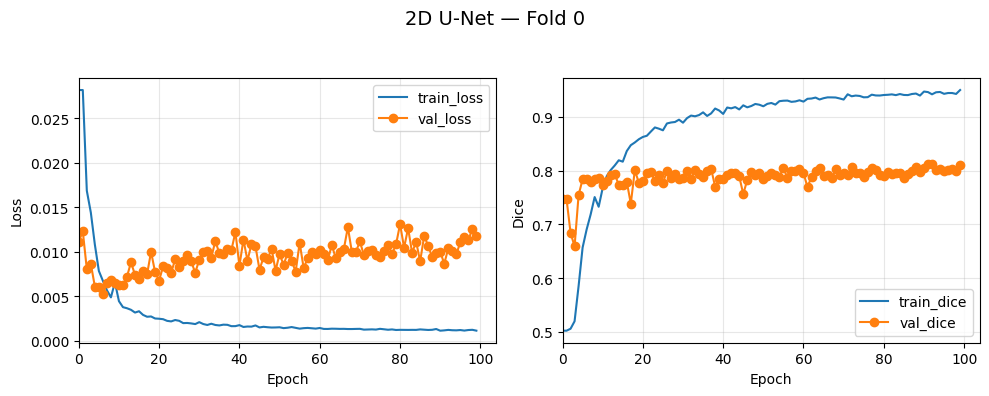

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.



================ FOLD fold1 ================


=== Fold fold1 paths ===
  train: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold1\train
  val:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold1\val
  test:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold1\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold1\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold1\train\label_gtvp (exists=True)
[LungDataset] Found 10376 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\split


Scanning slices for class balance:  69%|████████████████████████████▎            | 7153/10376 [00:13<00:06, 481.10it/s]


Scanning slices for class balance: 100%|████████████████████████████████████████| 10376/10376 [00:19<00:00, 525.21it/s]


  positives: 2432/10376 (23.4%)
  sample batch tumor slices: 4 / 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

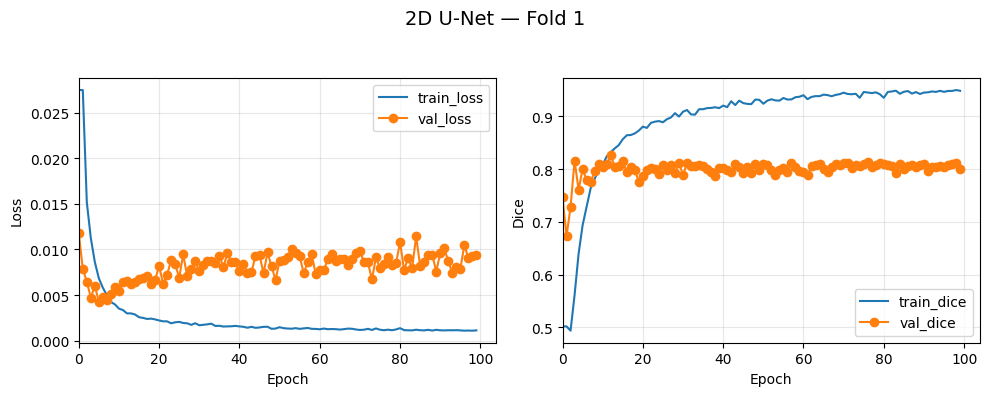

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.



================ FOLD fold2 ================


=== Fold fold2 paths ===
  train: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold2\train
  val:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold2\val
  test:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold2\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold2\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold2\train\label_gtvp (exists=True)
[LungDataset] Found 9918 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits


Scanning slices for class balance:  71%|█████████████████████████████▋            | 7020/9918 [00:13<00:06, 469.81it/s]


Scanning slices for class balance: 100%|██████████████████████████████████████████| 9918/9918 [00:19<00:00, 514.32it/s]


  positives: 2425/9918 (24.5%)
  sample batch tumor slices: 6 / 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

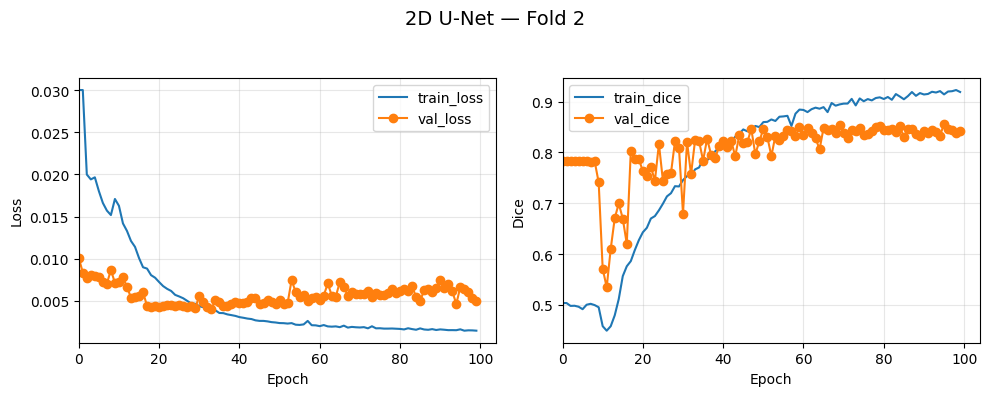

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.



================ FOLD fold3 ================


=== Fold fold3 paths ===
  train: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold3\train
  val:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold3\val
  test:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold3\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold3\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold3\train\label_gtvp (exists=True)
[LungDataset] Found 10599 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\split


Scanning slices for class balance:  65%|██████████████████████████▋              | 6890/10599 [00:13<00:06, 541.21it/s]


Scanning slices for class balance: 100%|████████████████████████████████████████| 10599/10599 [00:21<00:00, 496.96it/s]


  positives: 2543/10599 (24.0%)
  sample batch tumor slices: 4 / 8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

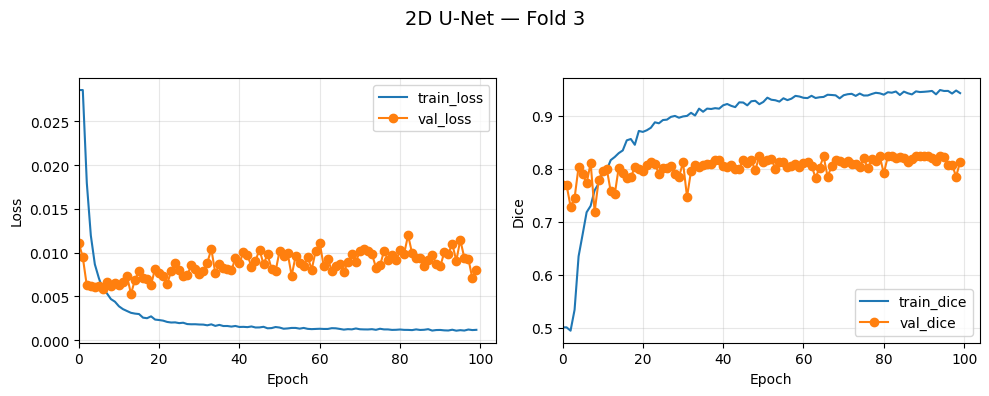

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.



================ FOLD fold4 ================


=== Fold fold4 paths ===
  train: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold4\train
  val:   E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold4\val
  test:  E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test
[LungDataset] root      = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold4\train
[LungDataset] img_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold4\train\image (exists=True)
[LungDataset] lbl_root  = E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold4\train\label_gtvp (exists=True)
[LungDataset] Found 10417 image .npy files under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\split


Scanning slices for class balance:  73%|██████████████████████████████           | 7648/10417 [00:13<00:04, 581.89it/s]


Scanning slices for class balance: 100%|████████████████████████████████████████| 10417/10417 [00:18<00:00, 573.84it/s]
GPU available: True (cuda), used: True


  positives: 2474/10417 (23.7%)
  sample batch tumor slices: 4 / 8


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | UNet              | 7.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

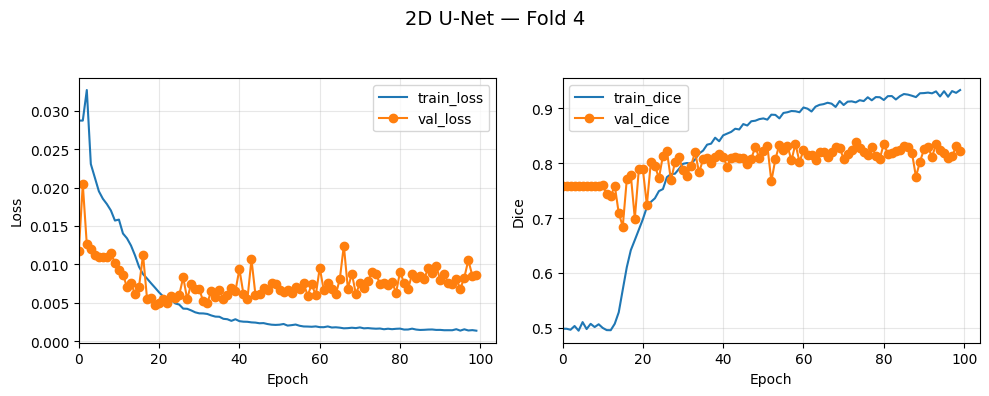

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


In [56]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torch.utils.data import DataLoader

# --------------------------------------------------
# Reproducibility
# --------------------------------------------------
SEED = 1337
pl.seed_everything(SEED, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

use_gpu    = torch.cuda.is_available()
NUM_FOLDS  = 5
batch_size = 8
num_workers = 10   # can increase later if stable

plots_root = Path("plots_2d_unet")

for fold_idx in range(NUM_FOLDS):
    fold_name = f"fold{fold_idx}"
    print(f"\n================ FOLD {fold_name} ================\n")

    # 1) datasets for this fold (you already have these helpers)
    train_dataset, val_dataset, test_dataset = build_datasets_for_fold(
        fold_idx,
        seq_train=seq,   # imgaug pipeline for training
    )

    # 2) weighted sampler for this fold’s training set
    sampler = compute_sampler_for_dataset(train_dataset)

    # quick sanity check of tumor fraction in one batch
    tmp_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=True,
    )
    batch_ct, batch_mask = next(iter(tmp_loader))
    tumor_flags = (batch_mask[:, 0].sum(dim=(1, 2)) > 0)
    print("  sample batch tumor slices:", tumor_flags.sum().item(), "/", batch_size)
    del tmp_loader

    # 3) final loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0),
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=(num_workers > 0),
    )

    # 4) model for this fold
    model = TumorSegmentation(lr=1e-4)

    # 5) callbacks & logger
    ckpt_loss = ModelCheckpoint(
        dirpath=f"ckpts_2d_unet/{fold_name}/loss",
        filename="loss-{epoch:03d}-{val_loss:.4f}",
        monitor="val_loss",
        mode="min",
        save_top_k=5,
        save_last=True,
    )
    ckpt_dice = ModelCheckpoint(
        dirpath=f"ckpts_2d_unet/{fold_name}/dice",
        filename="dice-{epoch:03d}-{val_dice:.4f}",
        monitor="val_dice",
        mode="max",
        save_top_k=3,
    )

    progress_bar = TQDMProgressBar(refresh_rate=1)

    live_cb = LiveEpochCurves(
        title=f"2D U-Net — Fold {fold_idx}",
        save_dir=plots_root,
        base_filename=f"fold{fold_idx}",
    )

    logger = TensorBoardLogger(
        save_dir="./logs_2d_unet",
        name="folds",
        version=fold_name,   # separate TB run per fold
    )

    # 6) Trainer
    trainer = pl.Trainer(
        accelerator="gpu" if use_gpu else "cpu",
        devices=1 if use_gpu else None,
        logger=logger,
        callbacks=[progress_bar, live_cb, ckpt_loss, ckpt_dice],
        enable_progress_bar=True,
        log_every_n_steps=1,
        check_val_every_n_epoch=1,
        num_sanity_val_steps=0,
        max_epochs=100,
    )

    # 7) train this fold
    trainer.fit(model, train_loader, val_loader)

## Numpy utilities for Dice, IoU, HD95, and largest connected component
This code defines evaluation helpers for binary masks in 2D/3D: Dice and IoU (treating any >0 as foreground), symmetric 95th-percentile Hausdorff distance (HD95) with physical spacing, and a function to keep only the largest connected component. These are used to compute robust, geometry-aware segmentation metrics and to optionally post-process predictions by removing small spurious regions.

In [88]:
import numpy as np
import torch
from pathlib import Path
from typing import List, Tuple, Dict
import re
import scipy.ndimage as ndi


def dice_binary_np(gt: np.ndarray, pred: np.ndarray, eps: float = 1e-6) -> float:
    """Dice for binary numpy masks (any >0 is foreground)."""
    gt = (gt > 0).astype(np.uint8)
    pred = (pred > 0).astype(np.uint8)

    inter = np.logical_and(gt, pred).sum()
    s_gt = gt.sum()
    s_pr = pred.sum()

    # both empty → perfect
    if s_gt == 0 and s_pr == 0:
        return 1.0
    return float((2.0 * inter + eps) / (s_gt + s_pr + eps))


def iou_binary_np(gt: np.ndarray, pred: np.ndarray, eps: float = 1e-6) -> float:
    """IoU for binary numpy masks (any >0 is foreground)."""
    gt = (gt > 0).astype(np.uint8)
    pred = (pred > 0).astype(np.uint8)

    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()

    if union == 0:
        return 1.0
    return float((inter + eps) / (union + eps))


def hd95_binary_nd(gt: np.ndarray,
                   pred: np.ndarray,
                   spacing: Tuple[float, ...]) -> float:
    """
    Symmetric 95th percentile Hausdorff distance for 2D or 3D binary masks.
    `spacing` must have length == gt.ndim, in the same axis order.
    """
    gt = (gt > 0).astype(bool)
    pred = (pred > 0).astype(bool)

    gt_sum = gt.sum()
    pr_sum = pred.sum()

    # both empty
    if gt_sum == 0 and pr_sum == 0:
        return 0.0
    # only one empty
    if gt_sum == 0 or pr_sum == 0:
        return float("inf")

    # Distance transforms of the complement
    dt_gt = ndi.distance_transform_edt(~gt, sampling=spacing)
    dt_pr = ndi.distance_transform_edt(~pred, sampling=spacing)

    # Surface distances
    sds_gt = dt_pr[gt]   # distances from GT surface to prediction
    sds_pr = dt_gt[pred] # distances from pred surface to GT
    sds = np.concatenate([sds_gt, sds_pr])
    if sds.size == 0:
        return 0.0
    return float(np.percentile(sds, 95))


def largest_component_nd(mask: np.ndarray) -> np.ndarray:
    """Keep only the largest connected component (2D or 3D)."""
    if mask.sum() == 0:
        return mask
    lab, n = ndi.label(mask.astype(np.uint8))
    if n == 0:
        return mask
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0
    keep = sizes.argmax()
    return (lab == keep).astype(mask.dtype)

# Load best 2D U-Net checkpoints (highest val Dice) for 5-fold ensemble
This code searches each fold’s 2D U-Net checkpoint directory, picks the model with the highest validation Dice, and loads those five “best-Dice” checkpoints onto the current device in eval mode. These fold-specific models are then ready to be used together as an ensemble for test-time inference and evaluation.

In [89]:
NUM_FOLDS = 5

def get_best_dice_ckpt_for_fold_2d(fold_idx: int) -> Path:
    """
    Find the dice checkpoint with the highest val_dice for this fold.
    Looks under: ckpts_2d_unet/fold{fold_idx}/dice
    """
    dice_dir = Path(f"ckpts_2d_unet/fold{fold_idx}/dice")
    if not dice_dir.is_dir():
        raise FileNotFoundError(f"{dice_dir} does not exist")

    ckpts = sorted(dice_dir.glob("dice-epoch=*-val_dice=*.ckpt"))
    if not ckpts:
        raise FileNotFoundError(f"No dice checkpoints found in {dice_dir}")

    def extract_val_dice(p: Path) -> float:
        # match numbers like 0.7468, 0.8, etc.
        m = re.search(r"val_dice=([0-9]*\.?[0-9]+)", p.name)
        if not m:
            return -1.0
        return float(m.group(1))

    ckpts_sorted = sorted(ckpts, key=extract_val_dice, reverse=True)
    best = ckpts_sorted[0]
    print(f"[Fold {fold_idx}] best Dice ckpt: {best.name} (val_dice={extract_val_dice(best):.4f})")
    return best

# ---- load all 5 models ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

fold_ckpts_2d: List[Path] = [get_best_dice_ckpt_for_fold_2d(k) for k in range(NUM_FOLDS)]

fold_models_2d: List[torch.nn.Module] = []
for fold_idx, ckpt_path in enumerate(fold_ckpts_2d):
    print(f"[Ensemble-2D] Loading fold {fold_idx} from {ckpt_path}")
    m = TumorSegmentation.load_from_checkpoint(checkpoint_path=str(ckpt_path))
    m.to(device)
    m.eval()
    fold_models_2d.append(m)

Using device: cuda
[Fold 0] best Dice ckpt: dice-epoch=092-val_dice=0.8117.ckpt (val_dice=0.8117)
[Fold 1] best Dice ckpt: dice-epoch=012-val_dice=0.8264.ckpt (val_dice=0.8264)
[Fold 2] best Dice ckpt: dice-epoch=095-val_dice=0.8564.ckpt (val_dice=0.8564)
[Fold 3] best Dice ckpt: dice-epoch=094-val_dice=0.8250.ckpt (val_dice=0.8250)
[Fold 4] best Dice ckpt: dice-epoch=073-val_dice=0.8383.ckpt (val_dice=0.8383)
[Ensemble-2D] Loading fold 0 from ckpts_2d_unet\fold0\dice\dice-epoch=092-val_dice=0.8117.ckpt
[Ensemble-2D] Loading fold 1 from ckpts_2d_unet\fold1\dice\dice-epoch=012-val_dice=0.8264.ckpt
[Ensemble-2D] Loading fold 2 from ckpts_2d_unet\fold2\dice\dice-epoch=095-val_dice=0.8564.ckpt
[Ensemble-2D] Loading fold 3 from ckpts_2d_unet\fold3\dice\dice-epoch=094-val_dice=0.8250.ckpt
[Ensemble-2D] Loading fold 4 from ckpts_2d_unet\fold4\dice\dice-epoch=073-val_dice=0.8383.ckpt


# 2D U-Net Best-Checkpoint Ensemble — Test Evaluation (Slice + Volume)
Runs the 2D ensemble on .npy test slices, computes per-slice and per-case (3D) metrics, aggregates results, and prints overall performance.

In [92]:
from collections import defaultdict

# Adjust these if your base is named differently
BASE     = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")
PRE_ROOT = BASE / "Preprocessed_for_2D_Unet" / "splits"

TEST_IMG_ROOT   = PRE_ROOT / "test" / "image"
TEST_LABEL_ROOT = PRE_ROOT / "test" / "label_gtvp"

print("TEST_IMG_ROOT  :", TEST_IMG_ROOT)
print("TEST_LABEL_ROOT:", TEST_LABEL_ROOT)


@torch.no_grad()
def evaluate_2d_ensemble_from_npy(
    img_root: Path,
    label_root: Path,
    models: List[torch.nn.Module],
    device: torch.device,
    pos_thresh: float = 0.5,
    spacing_xy: Tuple[float, float] = (1.0, 1.0),  # (dy, dx) in mm
    spacing_z: float = 1.0,                        # slice thickness in mm
    postprocess_lcc: bool = False,
):
    """
    Ensembling over 5 folds for the test set stored as:
      img_root  / Lung_XXX / <k>.npy
      label_root/ Lung_XXX / <k>.npy

    Returns:
      per_slice_results_2d: List[dict]
      per_case_results_2d : List[dict]
    """
    for m in models:
        m.to(device)
        m.eval()

    # Containers
    per_slice_results: List[Dict] = []
    case_pred_slices  = defaultdict(list)  # case_id -> [D,H,W]
    case_gt_slices    = defaultdict(list)
    case_slice_metrics = defaultdict(list)

    case_dirs = sorted([d for d in img_root.iterdir() if d.is_dir()])
    print(f"Found {len(case_dirs)} test cases under {img_root}")

    total_slices = 0

    for case_dir in case_dirs:
        case_name = case_dir.name        # e.g. "Lung_054"
        # use numeric id like "054" to match your 3D code
        case_id = case_name.split("_")[-1]

        label_case_dir = label_root / case_name
        if not label_case_dir.is_dir():
            raise FileNotFoundError(f"Missing label dir for {case_name}: {label_case_dir}")

        slice_files = sorted(case_dir.glob("*.npy"), key=lambda p: int(p.stem))
        print(f"  [{case_id}] {len(slice_files)} slices")

        for sf in slice_files:
            slice_idx = int(sf.stem)
            img_np = np.load(sf)                         # (H,W) or (1,H,W)
            lab_np = np.load(label_case_dir / sf.name)   # same shape

            # Ensure shape (H,W)
            if img_np.ndim == 3:
                img_np_2d = img_np[0]
            elif img_np.ndim == 2:
                img_np_2d = img_np
            else:
                raise ValueError(f"Unexpected image shape {img_np.shape} in {sf}")

            if lab_np.ndim == 3:
                lab_np_2d = lab_np[0]
            elif lab_np.ndim == 2:
                lab_np_2d = lab_np
            else:
                raise ValueError(f"Unexpected label shape {lab_np.shape} in {label_case_dir / sf.name}")

            # ---- 2D tensor [B=1, C=1, H, W] ----
            ct_t = torch.from_numpy(img_np_2d).unsqueeze(0).unsqueeze(0).float().to(device)

            # NOTE: if LungDataset applied extra normalization (e.g. mean/std),
            #       apply the same here to ct_t before feeding the model.

            # ---- ensemble over models ----
            probs_list = []
            for m in models:
                logits = m(ct_t)          # [1,1,H,W]
                probs  = torch.sigmoid(logits)
                probs_list.append(probs.detach().cpu())

            probs_stack = torch.stack(probs_list, dim=0)   # [M,1,1,H,W]
            prob_mean   = probs_stack.mean(dim=0)[0, 0].numpy().astype(np.float32)  # [H,W]

            pred_slice = (prob_mean > pos_thresh).astype(np.uint8)
            gt_slice   = (lab_np_2d > 0).astype(np.uint8)

            # ---- per-slice metrics (2D) ----
            d2  = dice_binary_np(gt_slice, pred_slice)
            j2  = iou_binary_np(gt_slice, pred_slice)
            hd2 = hd95_binary_nd(gt_slice, pred_slice, spacing=spacing_xy)

            per_slice_results.append({
                "case_id":   case_id,
                "slice_idx": slice_idx,
                "dice_2d":   d2,
                "iou_2d":    j2,
                "hd95_2d":   hd2,
            })

            case_pred_slices[case_id].append(pred_slice)
            case_gt_slices[case_id].append(gt_slice)
            case_slice_metrics[case_id].append((d2, j2, hd2))

            total_slices += 1

    print(f"\n[Ensemble-2D] Processed {total_slices} slices total.\n")

    # ---- aggregate per case into 3D volumes ----
    per_case_results: List[Dict] = []

    for case_id in sorted(case_pred_slices.keys()):
        pred_stack = np.stack(case_pred_slices[case_id], axis=0)  # [D,H,W]
        gt_stack   = np.stack(case_gt_slices[case_id],   axis=0)  # [D,H,W]

        if postprocess_lcc:
            pred_stack = largest_component_nd(pred_stack)

        # 3D metrics (D,H,W) with spacing_z, spacing_y, spacing_x
        d3  = dice_binary_np(gt_stack, pred_stack)
        j3  = iou_binary_np(gt_stack, pred_stack)
        hd3 = hd95_binary_nd(gt_stack, pred_stack,
                             spacing=(spacing_z, spacing_xy[0], spacing_xy[1]))

        slice_metrics = np.asarray(case_slice_metrics[case_id])  # [N_slices, 3]
        d2_mean  = float(slice_metrics[:, 0].mean())
        j2_mean  = float(slice_metrics[:, 1].mean())
        hd2_mean = float(slice_metrics[:, 2].mean())

        row = {
            "case_id":      case_id,
            "dice_3d":      d3,
            "iou_3d":       j3,
            "hd95_3d":      hd3,
            "dice_2d_mean": d2_mean,
            "iou_2d_mean":  j2_mean,
            "hd95_2d_mean": hd2_mean,
            "num_slices":   pred_stack.shape[0],
        }
        per_case_results.append(row)

    # ---- print per-case summary ----
    print("Per-case 2D-ensemble metrics (3D volume + mean over slices):")
    for r in per_case_results:
        print(
            f"  {r['case_id']}: "
            f"3D Dice={r['dice_3d']:.4f} | 3D IoU={r['iou_3d']:.4f} | 3D HD95={r['hd95_3d']:.2f} mm  "
            f"|| mean 2D Dice={r['dice_2d_mean']:.4f} | mean 2D IoU={r['iou_2d_mean']:.4f} "
            f"| mean 2D HD95={r['hd95_2d_mean']:.2f} mm  "
            f"(slices={r['num_slices']})"
        )

    # =========================================================
    # Overall averages
    #   * 3D volumetric metrics: average over cases
    #   * 2D slice-wise metrics: average over ALL slices of ALL cases
    # =========================================================
    # 3D (per-case) metrics
    all_d3  = np.array([r["dice_3d"] for r in per_case_results], float)
    all_j3  = np.array([r["iou_3d"]  for r in per_case_results], float)
    all_hd3 = np.array([r["hd95_3d"] for r in per_case_results], float)

    finite_hd3 = np.isfinite(all_hd3)
    mean_hd3   = float(all_hd3[finite_hd3].mean()) if finite_hd3.any() else float("inf")

    # 2D metrics across ALL slices (population of slices)
    all_d2  = np.array([s["dice_2d"] for s in per_slice_results], float)
    all_j2  = np.array([s["iou_2d"]  for s in per_slice_results], float)
    all_hd2 = np.array([s["hd95_2d"] for s in per_slice_results], float)

    finite_hd2 = np.isfinite(all_hd2)
    mean_hd2   = float(all_hd2[finite_hd2].mean()) if finite_hd2.any() else float("inf")

    print("\nFinal 2D-ensemble summary on test set:")
    print(f"  3D volumetric mean Dice              : {all_d3.mean():.4f}")
    print(f"  3D volumetric mean IoU               : {all_j3.mean():.4f}")
    print(f"  3D volumetric mean HD95              : {mean_hd3:.2f} mm (finite cases)")
    print(f"  2D slice-wise mean Dice (all slices) : {all_d2.mean():.4f}")
    print(f"  2D slice-wise mean IoU  (all slices) : {all_j2.mean():.4f}")
    print(f"  2D slice-wise mean HD95 (all slices) : {mean_hd2:.2f} mm (finite slices)")

    return per_slice_results, per_case_results

TEST_IMG_ROOT  : E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test\image
TEST_LABEL_ROOT: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test\label_gtvp


# Run 2D Ensemble Inference on the Test Set
Executes the 2D ensemble using the best checkpoints, applies thresholding, computes slice-wise and case-level metrics, and returns aggregated test performance.

In [93]:
per_slice_results_2d, per_case_results_2d = evaluate_2d_ensemble_from_npy(
    img_root=TEST_IMG_ROOT,
    label_root=TEST_LABEL_ROOT,
    models=fold_models_2d,
    device=device,
    pos_thresh=0.5,
    spacing_xy=(1.0, 1.0),   # TODO: replace with actual (dy, dx) in mm if you know them
    spacing_z=1.0,           # TODO: replace with actual slice thickness in mm
    postprocess_lcc=False,   # set True if you want largest-component filtering
)


Found 40 test cases under E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\test\image
  [054] 116 slices
  [062] 140 slices
  [065] 92 slices
  [081] 107 slices
  [092] 148 slices
  [098] 117 slices
  [108] 236 slices
  [124] 81 slices
  [135] 81 slices
  [152] 99 slices
  [161] 99 slices
  [185] 77 slices
  [247] 88 slices
  [251] 85 slices
  [289] 117 slices
  [294] 105 slices
  [317] 106 slices
  [325] 81 slices
  [344] 121 slices
  [370] 90 slices
  [421] 134 slices
  [488] 103 slices
  [490] 120 slices
  [500] 94 slices
  [515] 94 slices
  [628] 132 slices
  [638] 97 slices
  [639] 97 slices
  [662] 105 slices
  [672] 108 slices
  [674] 97 slices
  [687] 112 slices
  [703] 103 slices
  [742] 91 slices
  [751] 96 slices
  [787] 131 slices
  [815] 123 slices
  [880] 72 slices
  [881] 143 slices
  [882] 125 slices

[Ensemble-2D] Processed 4363 slices total.

Per-case 2D-ensemble metrics (3D volume + mean over slices):
  054: 3D Dice=0.7053 | 

# 2D U-Net Ensemble Evaluation & Checkpoint Utilities (Last-Loss Ensemble)
This script provides utilities to:

1. Compute Dice, IoU, HD95, and largest connected components.

2. Run a full 2D ensemble evaluation directly from .npy slice folders, producing per-slice and per-case metrics.

3. Select either best-Dice or last-loss checkpoints per fold for ensembling.

4. Load all folds’ checkpoints and run the final ensemble on the test set.

(Purpose: Enables consistent, automated evaluation of multi-fold 2D U-Net ensembles with standardized metrics and checkpoint selection.)

In [99]:
import os
import re
from pathlib import Path
from typing import List, Tuple, Optional, Dict, Any, Union

import numpy as np
import torch
from torch import nn

# You will need SciPy for HD95
import scipy.ndimage as ndi
from scipy.ndimage import distance_transform_edt, binary_erosion


# ------------------------------------------------------------------
# 0) Simple metrics helpers
# ------------------------------------------------------------------
def dice_binary(gt: np.ndarray, pred: np.ndarray, empty_ok_as: float = 1.0) -> float:
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    s_gt = gt.sum()
    s_pr = pred.sum()
    if s_gt == 0 and s_pr == 0:
        return float(empty_ok_as)
    if s_gt + s_pr == 0:
        return 0.0
    return float(2.0 * inter / (s_gt + s_pr))


def iou_binary(gt: np.ndarray, pred: np.ndarray, empty_ok_as: float = 1.0) -> float:
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    union = np.logical_or(gt, pred).sum()
    inter = np.logical_and(gt, pred).sum()
    if gt.sum() == 0 and pred.sum() == 0:
        return float(empty_ok_as)
    if union == 0:
        return 0.0
    return float(inter / union)


def largest_component(mask: np.ndarray) -> np.ndarray:
    """Largest connected component for 2D or 3D masks."""
    if mask.sum() == 0:
        return mask
    lab, n = ndi.label(mask.astype(np.uint8))
    if n == 0:
        return mask
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0
    keep = sizes.argmax()
    return (lab == keep).astype(mask.dtype)


def hd95_binary(
    gt: np.ndarray,
    pred: np.ndarray,
    spacing: Tuple[float, ...] = (1.0, 1.0, 1.0),
) -> float:
    """
    Symmetric 95th percentile Hausdorff distance between two binary masks.
    Works for 2D or 3D, but here we mainly use 3D (Z,H,W) or (1,H,W).

    If both gt and pred are empty -> 0.0
    If exactly one is empty -> inf
    """
    gt = gt.astype(bool)
    pred = pred.astype(bool)

    if gt.sum() == 0 and pred.sum() == 0:
        return 0.0
    if gt.sum() == 0 or pred.sum() == 0:
        return float("inf")

    if gt.shape != pred.shape:
        raise ValueError(f"gt and pred must have same shape, got {gt.shape} vs {pred.shape}")

    ndim = gt.ndim
    if len(spacing) != ndim:
        spacing = tuple(spacing)[:ndim]

    # surface voxels = mask XOR eroded(mask)
    footprint = np.ones([3] * ndim, dtype=bool)

    gt_eroded = binary_erosion(gt, structure=footprint, border_value=0)
    pr_eroded = binary_erosion(pred, structure=footprint, border_value=0)

    surf_gt = np.logical_xor(gt, gt_eroded)
    surf_pr = np.logical_xor(pred, pr_eroded)

    if not surf_gt.any() or not surf_pr.any():
        # degenerate surfaces -> fallback to distance between all mask voxels
        surf_gt = gt
        surf_pr = pred

    # distance from gt surface to pred surface
    dt_pr = distance_transform_edt(~surf_pr, sampling=spacing)
    dists_gt_to_pr = dt_pr[surf_gt]

    # distance from pred surface to gt surface
    dt_gt = distance_transform_edt(~surf_gt, sampling=spacing)
    dists_pr_to_gt = dt_gt[surf_pr]

    dists = np.concatenate([dists_gt_to_pr, dists_pr_to_gt], axis=0)
    if dists.size == 0:
        return 0.0

    return float(np.percentile(dists, 95))


# ------------------------------------------------------------------
# 1) Evaluate ensemble directly from .npy folders (image / label_gtvp)
# ------------------------------------------------------------------
@torch.no_grad()
def evaluate_2d_ensemble_from_npy(
    root: Union[str, Path],
    models: List[torch.nn.Module],
    device: Optional[torch.device] = None,
    pos_thresh: float = 0.5,
    spacing_xy: Tuple[float, float] = (1.0, 1.0),
    spacing_z: float = 1.0,
    postprocess_lcc: bool = False,
) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """
    root/
      image/<case_id>/*.npy
      label_gtvp/<case_id>/*.npy

    Returns:
      per_slice_results: list of dicts with 2D metrics
      per_case_results : list of dicts with 3D + aggregated 2D metrics
    """
    root = Path(root)
    img_root = root / "image"
    lab_root = root / "label_gtvp"

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # put all models on device + eval once
    for m in models:
        m.to(device)
        m.eval()

    case_ids = sorted([d.name for d in img_root.iterdir() if d.is_dir()])

    per_slice_results: List[Dict[str, Any]] = []
    per_case_results: List[Dict[str, Any]] = []

    # population-level accumulators (all slices)
    all_dice_2d: List[float] = []
    all_iou_2d: List[float] = []
    all_hd95_2d: List[float] = []

    spacing_3d = (spacing_z, spacing_xy[0], spacing_xy[1])

    print(f"Running 2D ensemble on {len(case_ids)} test cases ...")

    # -------- per-case loop --------
    for case_id in case_ids:
        img_dir = img_root / case_id
        lab_dir = lab_root / case_id

        # slice files: 0.npy, 1.npy, ...
        slice_files = sorted(
            img_dir.glob("*.npy"),
            key=lambda p: int(p.stem)
        )
        if not slice_files:
            print(f"[WARN] No slices for case {case_id}, skipping.")
            continue

        gt_slices = []
        pred_slices = []

        slice_dices: List[float] = []
        slice_ious: List[float] = []
        slice_hd95s: List[float] = []

        # -------- per-slice ensemble prediction --------
        for sf in slice_files:
            slice_idx = int(sf.stem)       # 0, 1, 2, ...

            img_np = np.load(sf)                 # [H,W] or [1,H,W]
            lab_np = np.load(lab_dir / sf.name)  # [H,W] or [1,H,W]

            img_np = np.asarray(img_np, np.float32)
            lab_np = np.asarray(lab_np)

            if img_np.ndim == 2:
                img_np = img_np[None, ...]   # [1,H,W]
            if lab_np.ndim == 2:
                lab_np = lab_np[None, ...]   # [1,H,W]

            gt = (lab_np[0] > 0).astype(np.uint8)

            # model input: [B,1,H,W]
            ct = torch.from_numpy(img_np).unsqueeze(0).float().to(device)  # [1,1,H,W]

            # ensemble logits
            logits_sum = None
            for m in models:
                out = m(ct)   # [1,1,H,W]
                logits_sum = out if logits_sum is None else (logits_sum + out)
            logits_mean = logits_sum / float(len(models))

            prob = torch.sigmoid(logits_mean)[0, 0].detach().cpu().numpy()  # [H,W]
            pred = (prob > pos_thresh).astype(np.uint8)

            if postprocess_lcc:
                pred = largest_component(pred)

            # 2D metrics (using 3D hd95 on a single-slice volume [1,H,W])
            d2 = dice_binary(gt, pred, empty_ok_as=1.0)
            j2 = iou_binary(gt, pred, empty_ok_as=1.0)
            gt_3d = gt[None, ...]
            pred_3d = pred[None, ...]
            h2 = hd95_binary(gt_3d, pred_3d, spacing=spacing_3d)

            per_slice_results.append(
                dict(
                    case_id=case_id,
                    slice_idx=slice_idx,
                    dice2d=float(d2),
                    iou2d=float(j2),
                    hd95_2d=float(h2),
                )
            )

            slice_dices.append(float(d2))
            slice_ious.append(float(j2))
            slice_hd95s.append(float(h2))

            all_dice_2d.append(float(d2))
            all_iou_2d.append(float(j2))
            all_hd95_2d.append(float(h2))

            gt_slices.append(gt)
            pred_slices.append(pred)

        # -------- 3D per-case metrics (stack slices along z) --------
        gt_vol = np.stack(gt_slices, axis=0)     # [D,H,W]
        pred_vol = np.stack(pred_slices, axis=0) # [D,H,W]

        if postprocess_lcc:
            pred_vol = largest_component(pred_vol)

        d3 = dice_binary(gt_vol, pred_vol, empty_ok_as=1.0)
        j3 = iou_binary(gt_vol, pred_vol, empty_ok_as=1.0)
        h3 = hd95_binary(gt_vol, pred_vol, spacing=spacing_3d)

        # per-case mean 2D metrics (HD95 uses finite slices only)
        mean_d2 = float(np.mean(slice_dices)) if slice_dices else 0.0
        mean_j2 = float(np.mean(slice_ious)) if slice_ious else 0.0
        hd95_arr = np.asarray(slice_hd95s, float)
        finite_mask = np.isfinite(hd95_arr)
        if finite_mask.any():
            mean_h2 = float(hd95_arr[finite_mask].mean())
        else:
            mean_h2 = float("inf")

        per_case_results.append(
            dict(
                case_id=case_id,
                num_slices=len(slice_files),
                dice3d=float(d3),
                iou3d=float(j3),
                hd95_3d=float(h3),
                dice2d_mean=mean_d2,
                iou2d_mean=mean_j2,
                hd95_2d_mean=mean_h2,
            )
        )

        h3_str = f"{h3:.2f}" if np.isfinite(h3) else "inf"
        mean_h2_str = f"{mean_h2:.2f}" if np.isfinite(mean_h2) else "inf"

        print(
            f"[Case {case_id}] 3D Dice={d3:.4f}, IoU={j3:.4f}, HD95={h3_str} mm | "
            f"2D mean Dice={mean_d2:.4f}, IoU={mean_j2:.4f}, HD95={mean_h2_str} mm"
        )

    # -------- population summaries --------
    if per_case_results:
        d3_all = np.array([r["dice3d"] for r in per_case_results], float)
        j3_all = np.array([r["iou3d"]  for r in per_case_results], float)
        h3_all = np.array([r["hd95_3d"] for r in per_case_results], float)

        print("\n=== 3D per-case summary (2D UNet ensemble) ===")
        print(f"  #cases: {len(per_case_results)}")
        print(f"  Mean Dice3D : {d3_all.mean():.4f}")
        print(f"  Mean IoU3D  : {j3_all.mean():.4f}")
        finite_h3 = h3_all[np.isfinite(h3_all)]
        if finite_h3.size > 0:
            print(f"  Mean HD95 3D (finite): {finite_h3.mean():.2f} mm")
        else:
            print("  Mean HD95 3D: inf (no finite values)")

    if per_slice_results:
        d2_all = np.array([r["dice2d"] for r in per_slice_results], float)
        j2_all = np.array([r["iou2d"]  for r in per_slice_results], float)
        h2_all = np.array([r["hd95_2d"] for r in per_slice_results], float)

        print("\n=== 2D slice-level population summary (all cases) ===")
        print(f"  #slices: {len(per_slice_results)}")
        print(f"  Mean Dice2D : {d2_all.mean():.4f}")
        print(f"  Mean IoU2D  : {j2_all.mean():.4f}")
        finite_h2 = h2_all[np.isfinite(h2_all)]
        if finite_h2.size > 0:
            print(f"  Mean HD95 2D (finite): {finite_h2.mean():.2f} mm")
        else:
            print("  Mean HD95 2D: inf (no finite values)")

    return per_slice_results, per_case_results


# ------------------------------------------------------------------
# 2) Helper to pick BEST-DICE checkpoint (optional utility)
# ------------------------------------------------------------------
def get_best_dice_ckpt_for_fold_2d(fold_idx: int) -> Path:
    """
    Pick the ckpt with the largest val_dice in:
      ckpts_2d_unet/fold{fold_idx}/dice
    """
    fold_name = f"fold{fold_idx}"
    dice_dir = Path(f"ckpts_2d_unet/{fold_name}/dice")
    ckpts = sorted(dice_dir.glob("dice-epoch=*-val_dice=*.ckpt"))
    if not ckpts:
        raise FileNotFoundError(f"No dice ckpts found in {dice_dir}")

    def extract_val_dice(p: Path) -> float:
        # Use stem so ".ckpt" is gone; then regex on stem
        stem = p.stem  # e.g. "dice-epoch=092-val_dice=0.8117"
        m = re.search(r"val_dice=([0-9.]+)$", stem)
        return float(m.group(1)) if m else -1.0

    ckpts_sorted = sorted(ckpts, key=extract_val_dice, reverse=True)
    best = ckpts_sorted[0]
    print(f"[Fold {fold_idx}] best Dice ckpt: {best.name} (val_dice={extract_val_dice(best):.4f})")
    return best


# ------------------------------------------------------------------
# 3) Helper to pick LAST-LOSS checkpoint (for ensemble you want)
# ------------------------------------------------------------------
def get_last_loss_ckpt_for_fold_2d(fold_idx: int) -> Path:
    """
    Returns the checkpoint corresponding to the final training epoch
    for this fold, as saved by the 'loss' ModelCheckpoint with
    save_last=True in ckpts_2d_unet/foldX/loss/last.ckpt.

    If 'last.ckpt' is missing, falls back to the highest-epoch
    loss checkpoint.
    """
    fold_name = f"fold{fold_idx}"
    loss_dir = Path(f"ckpts_2d_unet/{fold_name}/loss")

    # Preferred: explicit 'last.ckpt'
    last_path = loss_dir / "last.ckpt"
    if last_path.exists():
        print(f"[Fold {fold_idx}] last LOSS ckpt: {last_path.name}")
        return last_path

    # Fallback: highest-epoch loss-epoch=XXX-val_loss=YYY.ckpt
    ckpts = sorted(loss_dir.glob("loss-epoch=*-val_loss=*.ckpt"))
    if not ckpts:
        raise FileNotFoundError(f"No loss ckpts found in {loss_dir}")

    def extract_epoch(p: Path) -> int:
        m = re.search(r"epoch=(\d+)", p.name)
        return int(m.group(1)) if m else -1

    ckpts_sorted = sorted(ckpts, key=extract_epoch)
    last = ckpts_sorted[-1]
    print(f"[Fold {fold_idx}] last LOSS ckpt (by max epoch): {last.name}")
    return last


# ------------------------------------------------------------------
# 4) Load 5 last-loss models and evaluate ensemble
# ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
NUM_FOLDS = 5

# assumes TumorSegmentation and PRE_ROOT already defined above
fold_ckpts_2d_last_loss: List[Path] = [
    get_last_loss_ckpt_for_fold_2d(k) for k in range(NUM_FOLDS)
]

fold_models_2d_last_loss: List[torch.nn.Module] = []
for fold_idx, ckpt_path in enumerate(fold_ckpts_2d_last_loss):
    print(f"[Ensemble-2d-lastLoss] Loading fold {fold_idx} from {ckpt_path}")
    m = TumorSegmentation.load_from_checkpoint(str(ckpt_path), map_location=device)
    m.to(device).eval()
    fold_models_2d_last_loss.append(m)

print("\n=== 2D U-Net LAST-LOSS ensemble on test set ===")
per_slice_results_2d_last_loss, per_case_results_2d_last_loss = evaluate_2d_ensemble_from_npy(
    PRE_ROOT / "test",           # root with 'image' and 'label_gtvp'
    fold_models_2d_last_loss,    # list of 5 last-loss models
    device=device,
    pos_thresh=0.5,
    spacing_xy=(1.0, 1.0),       # replace with actual (dx, dy) if known
    spacing_z=1.0,               # replace with actual slice thickness if known
    postprocess_lcc=False,       # or True if you want LCC post-processing
)

Using device: cuda
[Fold 0] last LOSS ckpt: last.ckpt
[Fold 1] last LOSS ckpt: last.ckpt
[Fold 2] last LOSS ckpt: last.ckpt
[Fold 3] last LOSS ckpt: last.ckpt
[Fold 4] last LOSS ckpt: last.ckpt
[Ensemble-2d-lastLoss] Loading fold 0 from ckpts_2d_unet\fold0\loss\last.ckpt
[Ensemble-2d-lastLoss] Loading fold 1 from ckpts_2d_unet\fold1\loss\last.ckpt
[Ensemble-2d-lastLoss] Loading fold 2 from ckpts_2d_unet\fold2\loss\last.ckpt
[Ensemble-2d-lastLoss] Loading fold 3 from ckpts_2d_unet\fold3\loss\last.ckpt
[Ensemble-2d-lastLoss] Loading fold 4 from ckpts_2d_unet\fold4\loss\last.ckpt

=== 2D U-Net LAST-LOSS ensemble on test set ===
Running 2D ensemble on 40 test cases ...
[Case Lung_054] 3D Dice=0.6980, IoU=0.5361, HD95=11.00 mm | 2D mean Dice=0.8411, IoU=0.8270, HD95=0.68 mm
[Case Lung_062] 3D Dice=0.5718, IoU=0.4004, HD95=17.09 mm | 2D mean Dice=0.8204, IoU=0.7994, HD95=1.56 mm
[Case Lung_065] 3D Dice=0.6944, IoU=0.5319, HD95=6.00 mm | 2D mean Dice=0.8185, IoU=0.7978, HD95=1.16 mm
[Case Lun

# Visualize 2D Ensemble Predictions Slice-by-Slice (Animated)
Loads a CT and its label, normalizes and crops depth, resizes each slice to the 2D U-Net input size, runs a 5-model ensemble to get per-slice predictions, reorients slices for display, and renders an animation showing CT with ground truth (green) and ensemble prediction (orange). This lets you visually inspect segmentation quality across the full volume.

In [105]:
import nibabel as nib
import cv2
import numpy as np
import torch
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

# ---------------------------------------------------
# Config
# ---------------------------------------------------
THRESHOLD = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE = Path(r"E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split")

# Image file has '_0000', label file does NOT
CASE_ID_IMG = "Lung_247_0000"            # image filename stem
if CASE_ID_IMG.endswith("_0000"):
    CASE_ID_LABEL = CASE_ID_IMG[:-5]     # strip "_0000" -> "Lung_133"
else:
    CASE_ID_LABEL = CASE_ID_IMG

ct_path    = BASE / "splits" / "test" / "image"      / f"{CASE_ID_IMG}.nii.gz"
label_path = BASE / "splits" / "test" / "label_gtvp" / f"{CASE_ID_LABEL}.nii.gz"

print("CT path   :", ct_path)
print("Label path:", label_path)

# ---------------------------------------------------
# Load CT and label, normalize, and depth-crop (z >= 20)
# ---------------------------------------------------
ct_nii    = nib.load(str(ct_path))
label_nii = nib.load(str(label_path))

ct_vol    = ct_nii.get_fdata().astype(np.float32)      # [H, W, D]
label_vol = label_nii.get_fdata().astype(np.float32)   # [H, W, D]

# normalize CT (adapt if you used a different scheme)
ct_vol = ct_vol / 3071.0

# --- depth crop consistent with your preprocessing ---
if ct_vol.shape[-1] > 20:
    ct_vol    = ct_vol[:, :, 20:]
    label_vol = label_vol[:, :, 20:]

H, W, D = ct_vol.shape
print(f"{CASE_ID_IMG}: cropped volume shape = {ct_vol.shape} (H, W, D)")

# ---------------------------------------------------
# Helper: 2D reorientation (same as your previous viz)
# ---------------------------------------------------
def reorient_2d(a: np.ndarray) -> np.ndarray:
    """
    Flip vertically, then rotate -90° (clockwise).
    This matches the orientation you used for visualization.
    """
    return np.rot90(np.flipud(a), k=3)

# ---------------------------------------------------
# Run 5-fold LAST-LOSS ensemble on each slice
# ---------------------------------------------------
scan_slices = []   # CT slices (resized)
gt_slices   = []   # GT mask slices (resized, 0/1)
pred_slices = []   # ensemble prediction (0/1)

# make sure models are on the correct device and in eval mode
for m in fold_models_2d_last_loss:
    m.to(device)
    m.eval()

for z in range(D):
    # 1) original slice
    img = ct_vol[:, :, z]                               # [H, W]
    lab = (label_vol[:, :, z] > 0).astype(np.uint8)     # [H, W]

    # 2) resize to 256x256 (same as 2D U-Net training)
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
    lab_resized = cv2.resize(lab, (256, 256), interpolation=cv2.INTER_NEAREST)

    scan_slices.append(img_resized)
    gt_slices.append(lab_resized)

    # 3) prepare input tensor [B,1,H,W] for the models
    x = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).float().to(device)

    # 4) ensemble logits from 5 last-loss models
    logits_sum = None
    with torch.no_grad():
        for m in fold_models_2d_last_loss:
            out = m(x)  # [1,1,H,W]
            logits_sum = out if logits_sum is None else logits_sum + out

    logits_mean = logits_sum / float(len(fold_models_2d_last_loss))  # [1,1,H,W]
    prob = torch.sigmoid(logits_mean)[0, 0].detach().cpu().numpy()   # [H, W]
    pred = (prob > THRESHOLD).astype(np.uint8)

    pred_slices.append(pred)

print(f"Collected {len(scan_slices)} slices for case {CASE_ID_LABEL}.")

# ---------------------------------------------------
# Reorient for display
# ---------------------------------------------------
scan_r = [reorient_2d(s) for s in scan_slices]
gt_r   = [reorient_2d(s) for s in gt_slices]
pred_r = [reorient_2d(s) for s in pred_slices]

N = len(scan_r)

# ---------------------------------------------------
# Build animation: CT + GT (green) + ensemble pred (orange)
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(scan_r[0], cmap="bone", interpolation="nearest")

# GT overlay (green)
ov_gt = ax.imshow(
    np.ma.masked_where(gt_r[0] == 0, gt_r[0]),
    cmap="winter", alpha=0.35, interpolation="nearest"
)

# Ensemble prediction overlay (orange)
ov_pred = ax.imshow(
    np.ma.masked_where(pred_r[0] == 0, pred_r[0]),
    cmap="autumn", alpha=0.35, interpolation="nearest"
)

ax.set_title(f"{CASE_ID_LABEL} — slice 0")
ax.axis("off")

def update(i):
    im.set_data(scan_r[i])
    ov_gt.set_data(np.ma.masked_where(gt_r[i] == 0, gt_r[i]))
    ov_pred.set_data(np.ma.masked_where(pred_r[i] == 0, pred_r[i]))
    ax.set_title(f"{CASE_ID_LABEL} — slice {i}")
    return im, ov_gt, ov_pred

anim = animation.FuncAnimation(
    fig, update, frames=range(N), interval=80, blit=False
)

display(HTML(anim.to_jshtml()))
plt.close(fig)

CT path   : E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\test\image\Lung_247_0000.nii.gz
Label path: E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\splits\test\label_gtvp\Lung_247.nii.gz
Lung_247_0000: cropped volume shape = (512, 512, 88) (H, W, D)
Collected 88 slices for case Lung_247.
